# Zaitsev Anton | Exercise 9

## General Information

In this exercise we will try to predict links based on available features in the Facebook graph (**Group 8**). We will first randomly delete 10% of the edges in the network, train a ML model on the features of the available edges and then try to reconstruct the deleted 10% of the edges.

Our pipeline for the link prediction is as follows:
1. Load graph data.
2. Define positive (existing) and negative (non-existent) edges. Positive edges take label 1, negative edges take label 0.
3. Compute feature vectors for each edge.
4. Split data into train/test sets with a 90/10 split with stratification on the labels.
5. Train Random Forest and XGBoost models using Repeated Stratified K-Fold cross-validation.
6. Perform ensemble link prediction & evaluate the predictions using accuracy, AUROC, precision and ROC curve.

## Imports

In [67]:
!pip install xgboost


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, accuracy_score, roc_curve

In [69]:
random.seed(1)

## Global Variables

In [70]:
DATA_FOLDER = "../data/"

## Link Prediction Pipeline

### 1. Load Graph

In [71]:
def constructGraph(edges_path: str, directed: bool = False) -> nx.Graph:
    """
    Construct a graph from an edge list.

    Parameters:
        - edges_path (str): The path to the .edges file, which contains the edges of the graph.
        - directed (bool): If True, the graph will be treated as directed, creating a NetworkX DiGraph.
    
    Returns:
        - g (nx.Graph or nx.DiGraph): A NetworkX graph containing all the nodes and edges from the .edges file.
                                      Additionally, nodes present in the .feat file but missing in the .edges
                                      file will be added to the graph as disconnected nodes (without any edges).
    """
    # read graph from .edges file
    if directed:
        g = nx.read_edgelist(edges_path, create_using=nx.DiGraph(), nodetype=int)
    else:
        g = nx.read_edgelist(edges_path, create_using=nx.Graph(), nodetype=int)
    return g

In [72]:
# load facebook network, indirected graph
G_fb = constructGraph(edges_path=f"{DATA_FOLDER}3437.edges", directed=False)
G = G_fb.copy()

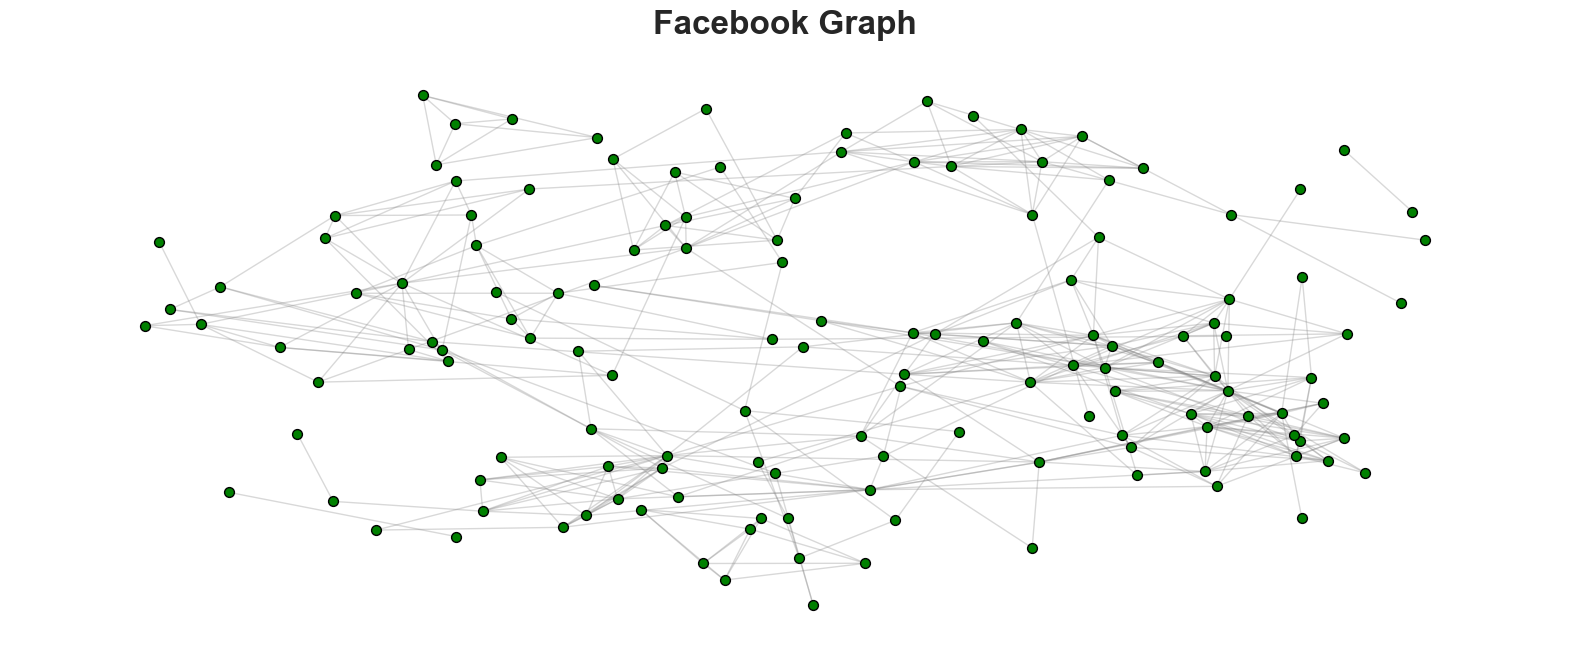

In [73]:
# plot G_fb
plt.figure(figsize=(20, 8))
pos = nx.spring_layout(G_fb, k=0.4)
nx.draw_networkx_nodes(G_fb, pos, node_color="green", node_size=50, edgecolors="black", linewidths=1)
nx.draw_networkx_edges(G_fb, pos, edge_color="gray", alpha=0.3)
plt.title("Facebook Graph", fontsize=24, fontweight="bold")
plt.axis('off')
plt.show()

### 2. Define Positive/Negative Edges

In [74]:
# get all positive (existing) edges
positive_edges = list(G.edges())
# generate negative (non-existent) edges
non_edges = list(nx.non_edges(G))
random.shuffle(non_edges)
negative_edges = non_edges
# combine positive and negative edges
all_edges = positive_edges + negative_edges
# define binary labels for each edge
labels = np.hstack([np.ones(len(positive_edges)), np.zeros(len(negative_edges))])

print(f"Number of positive edges: {len(positive_edges)}")
print(f"Number of negative edges: {len(negative_edges)}")
print(f"Random positive edge: {all_edges[0]}")
print(f"Random negative edge: {all_edges[-1]}")
print(f"Labels peek: {labels[:5], labels[-5:]}")


Number of positive edges: 407
Number of negative edges: 9323
Random positive edge: (3562, 3479)
Random negative edge: (3452, 3523)
Labels peek: (array([1., 1., 1., 1., 1.]), array([0., 0., 0., 0., 0.]))


### 3. Compute Feature Vector for Each Edge

In [75]:
shortest_paths = dict(nx.all_pairs_shortest_path_length(G))
def computeEdgeFeatures(G, u, v, shortest_paths=shortest_paths):
    """
    Computes common neighbors, jaccard coefficient, 
        adamic-adar score and shortest path length
        between nodes u and v in graph G as an edge feature vector.
    
    Parameters:
        - G (nx.Graph): Input graph.
        - u: node in G.
        - v: node in G.
        - shortest_paths (dict): Shortests paths from each node to every other node in the graph.
    
    Returns:
        - features (np.array): Edge between u and v converted to a feature vector.
    """
    # common neighbors
    cn_list = list(nx.common_neighbors(G, u, v))
    cn = len(cn_list)
    # jaccard coefficient
    union_size = len(set(G.neighbors(u)).union(G.neighbors(v)))
    jc = cn / union_size if union_size != 0 else 0
    # adamic-adar score (log)
    aa_score = sum(1 / G.degree(w) for w in cn_list if G.degree(w) > 1)
    # shortest path length
    if u in shortest_paths and v in shortest_paths[u]:
        spl = shortest_paths[u][v]
    else:
        # assign -1 for disconnected pairs
        spl = -1
    features = [cn, jc, aa_score, spl]
    return features

def computeEdgesFeatures(G, edges):
    """
    Computes common neighbors, jaccard coefficient, 
        adamic-adar score and shortest path length
        for each edge in edges.
    
    Parameters:
        - G (nx.Graph): Input graph.
        - edges (list): List of input edges.
    
    Returns:
        - features (np.array): Edges converted to feature vectors.
    """
    features = []
    for u, v in edges:
        edge_features = computeEdgeFeatures(G, u, v)
        features.append(edge_features)
    features = np.array(features)
    return features

In [76]:
# compute features for all edges
edge_features = computeEdgesFeatures(G, all_edges)
print(f"Features for a positive edge {all_edges[10]}: {edge_features[0]}")
print(f"Features for a negative edge {all_edges[-10]}: {edge_features[-1]}")

Features for a positive edge (3517, 3438): [4.         0.66666667 0.9        1.        ]
Features for a negative edge (3445, 3580): [ 0.  0.  0. -1.]


We will plot the distributions of features for positive and negative edges.

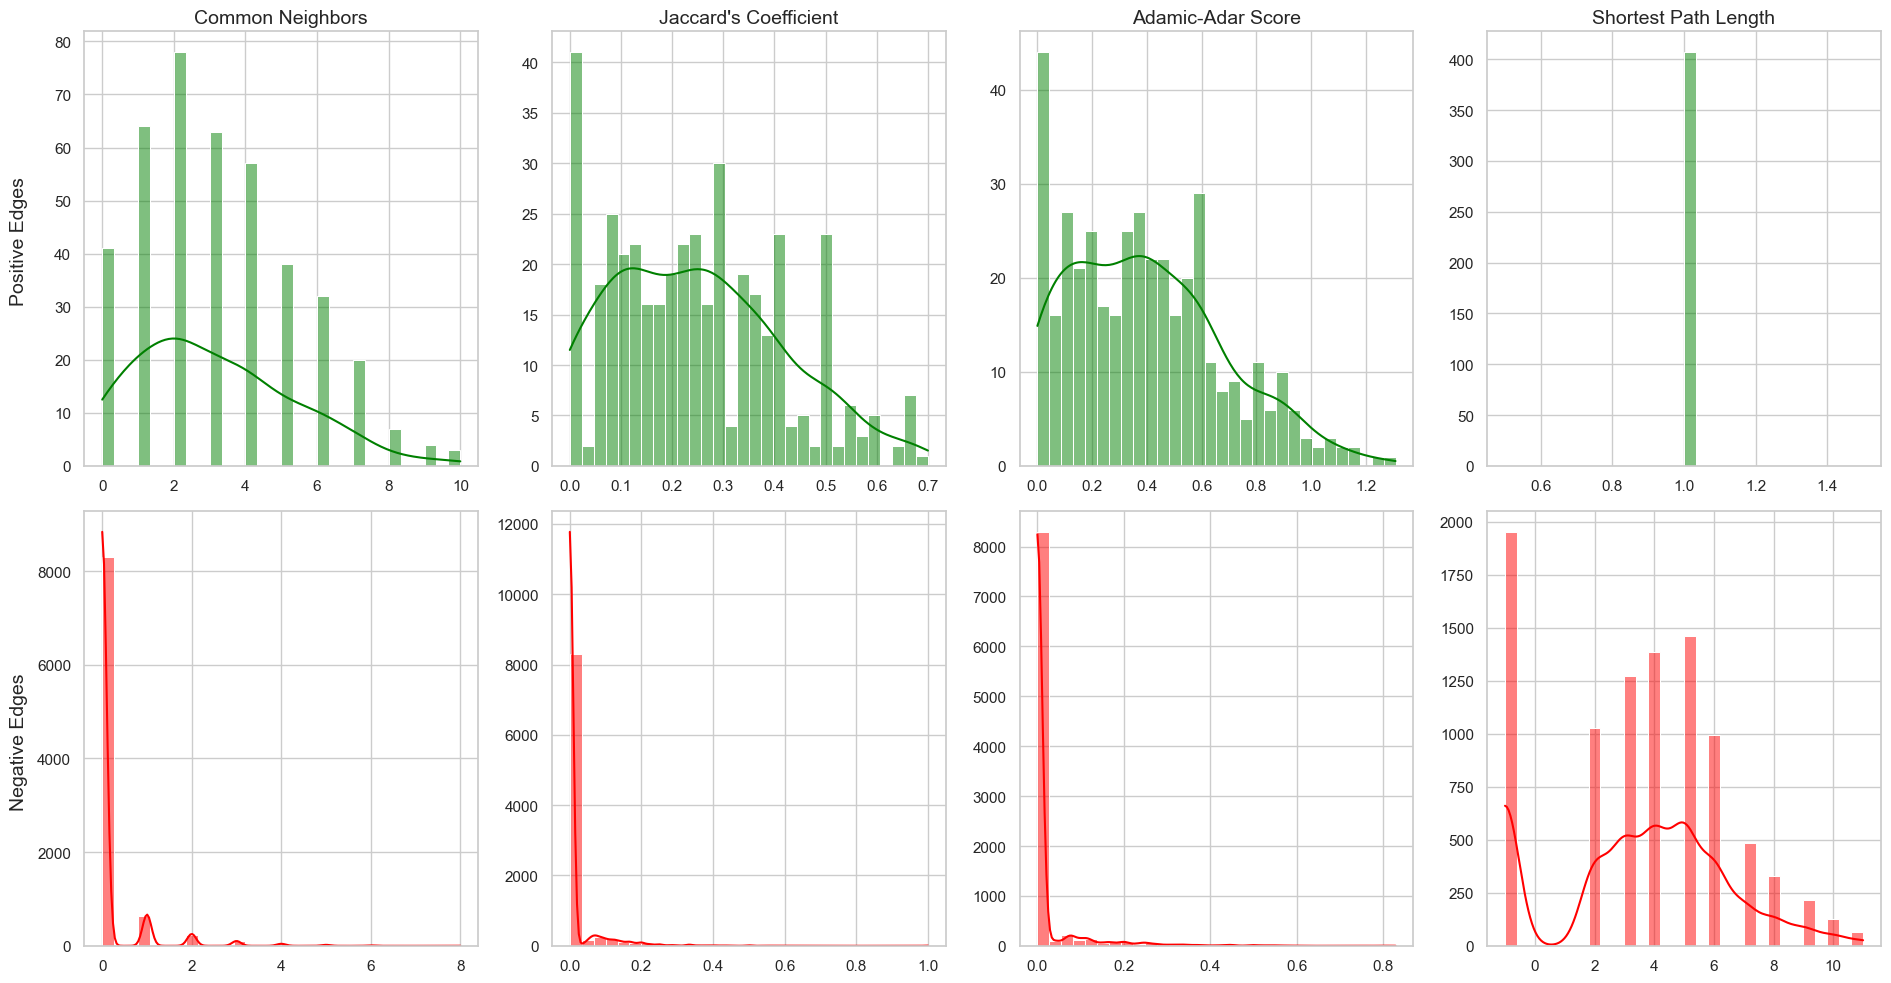

In [77]:
positive_features = edge_features[:len(positive_edges)]
negative_features = edge_features[len(positive_edges):]

feature_names = ["Common Neighbors", "Jaccard's Coefficient", "Adamic-Adar Score", "Shortest Path Length"]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
sns.set_theme(style="whitegrid")
for idx, feature in enumerate(feature_names):
    # positive edges
    sns.histplot(positive_features[:, idx], bins=30, kde=True, color="green", ax=axes[0, idx])
    axes[0, idx].set_title(f"{feature}", fontsize=14)
    axes[0, idx].set_xlabel("")
    axes[0, idx].set_ylabel("")
    # negative edges
    sns.histplot(negative_features[:, idx], bins=30, kde=True, color="red", ax=axes[1, idx])
    axes[1, idx].set_xlabel("")
    axes[1, idx].set_ylabel("")
fig.text(0.06, 0.75, "Positive Edges", ha="center", va="center", rotation="vertical", fontsize=14)
fig.text(0.06, 0.25, "Negative Edges", ha="center", va="center", rotation="vertical", fontsize=14)
plt.tight_layout(rect=[0.06, 0, 1, 1])
plt.show()

We see a clear difference between the features of existing and non-existent edges.

### 4. Split Data into Train/Test (10%) Sets

Now we split our data into train and test sets. Basically, the idea is as follows: we train the model on the train set, which includes existing and non-existing edges. Then, we evaluate our model on the remaining edges, which include 10% of the existing edges and 10% of non-existing edges.

In [78]:
original_indices = np.arange(len(all_edges))
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    edge_features, labels, original_indices, test_size=0.1, stratify=labels, random_state=1
)

### 5. Train Random Forest and LightGBM Models Using Repeated Stratified K-Fold Cross-Validation

In [79]:
# class weights for xgb (due to imbalanced data)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
# grid-search values
params_grid_rf = {
    "classifier__n_estimators": [64, 128, 256],
    "classifier__max_depth": [None, 4, 8, 16],
    "classifier__min_samples_split": [2, 4],
    "classifier__min_samples_leaf": [1, 2],
    "classifier__bootstrap": [True, False]
}
params_grid_xgb = {
    'classifier__n_estimators': [64, 128, 256],
    'classifier__max_depth': [2, 4, 8],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1],
    'classifier__colsample_bytree': [0.8, 1]
}
# cross-validation strategy
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

#### Random Forest Classifier

In [80]:
# data -> model pipeline
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(class_weight="balanced", random_state=1))
])
# metrics
scoring = {
    "AUC": make_scorer(roc_auc_score, response_method="predict_proba"),
    "precision": make_scorer(precision_score, zero_division=0),
    "accuracy": make_scorer(accuracy_score)
}
# grid-search
grid_search_rf = GridSearchCV(
    estimator=rf_pipeline, # rf pipeline
    param_grid=params_grid_rf, # rf grid params
    scoring="roc_auc",  # use AUROC as the primary scoring metric
    cv=cv_strategy, # cross-validation strategy
    n_jobs=-1, # use all processes to run in parallel
    verbose=2
)

In [81]:
# run grid search
grid_search_rf.fit(X_train, y_train)

Fitting 15 folds for each of 96 candidates, totalling 1440 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=1))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__max_depth': [None, 4, 8, 16],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 4],
                         'classifier__n_estimators': [64, 128, 256]},
             scoring='roc_auc', verbose=2)

#### XGBoost

In [82]:
# pipeline
xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", xgb.XGBClassifier(
        objective="binary:logistic",
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        random_state=1
    ))
])
# grid search
grid_search_xgb = GridSearchCV(
    estimator=xgb_pipeline, # xgboost pipeline
    param_grid=params_grid_xgb, # xgboost grid params
    scoring='roc_auc',  # use AUROC as the primary scoring metric
    cv=cv_strategy, # cross-validation strategy
    n_jobs=-1, # use all processes to run in parallel
    verbose=2
)

In [83]:
# run grid search
grid_search_xgb.fit(X_train, y_train)

Fitting 15 folds for each of 72 candidates, totalling 1080 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='l...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=1, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.8, 1],
                         'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': [2, 4, 8],
                         'classifier__n_estimators': [64, 128, 256],
                         'classifier__subsample': [0.8, 1]},
             scoring='roc_auc', verbose=2)

#### Retrieve Best Models

In [84]:
print("Best parameters for Random Forest:")
print(grid_search_rf.best_params_)
print("\nBest parameters for XGBoost:")
print(grid_search_xgb.best_params_)

Best parameters for Random Forest:
{'classifier__bootstrap': True, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 64}

Best parameters for XGBoost:
{'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 2, 'classifier__n_estimators': 64, 'classifier__subsample': 0.8}


In [85]:
# retrieve the best random forest classifier
best_rf_pipeline = grid_search_rf.best_estimator_
best_rf_pipeline.fit(X_train, y_train)
# retrieve the best xgboost model
best_xgb_pipeline = grid_search_xgb.best_estimator_
best_xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=64, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

### 6. Ensemble Link Prediction & Evaluation

In [86]:
# predict probabilities of existing links in the test set
rf_probs = best_rf_pipeline.predict_proba(X_test)[:, 1]
xgb_probs = best_xgb_pipeline.predict_proba(X_test)[:, 1]
# ensemble the probabilities using average
ensemble_probs = (rf_probs + xgb_probs) / 2
# convert probabilities to binary classes
ensemble_preds = (ensemble_probs >= 0.5).astype(int)


Ensemble Model Test Results:
Accuracy: 1.0000
AUROC: 1.0000
Precision: 1.0000


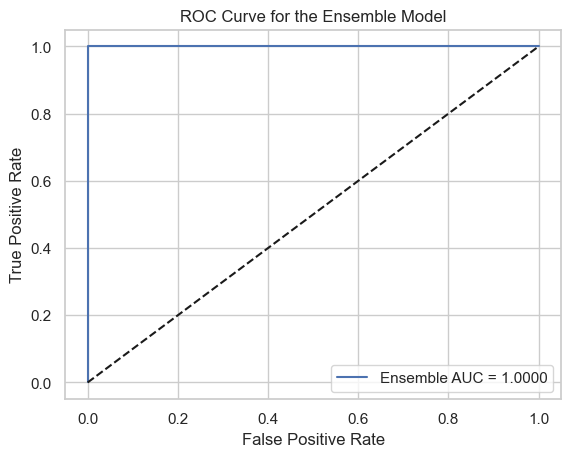

In [87]:
# calculate metrics
accuracy = accuracy_score(y_test, ensemble_preds)
auroc = roc_auc_score(y_test, ensemble_probs)
precision = precision_score(y_test, ensemble_preds, zero_division=0)

print("\nEnsemble Model Test Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, ensemble_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"Ensemble AUC = {auroc:.4f}")
plt.plot([0, 1], [0, 1], "k--")  # random predictions diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for the Ensemble Model")
plt.legend(loc="best")
plt.show()

The results seem too good. I believe this is because of our feature vector construction. If we compare the values for features between positive and negative edges, the difference is very clear, explaining the perfect accuracy of the model. Let's approach the edge prediction task differently, like we were to do in practice:
1. We take only positive edges from our test set.
2. For each first node in each edge:
    1. Compute the feature vectors between the current node and all other nodes in the graph.
    2. Predict which of these edges are positive and store these predictions
3. Compare the predicted positive edges with ground truth.

Note that this approach might be inefficient, as we have to compute feature vector for each node in the graph.

In [88]:
# step 1: map positive test indices back to edges
positive_indecies_test = indexes = np.where(y_test == 1)[0]
positive_test_edge_indices = test_indices[positive_indecies_test] # original indices in all_edges
positive_test_edges = [all_edges[i] for i in positive_test_edge_indices]
# step 2: get all nodes in positive_test_edges
positive_test_nodes = set([node for edge in positive_test_edges for node in edge])
# step 3: find all possible edges between positive_test_nodes and all the nodes in G
all_nodes = list(G.nodes())
possible_edges = set()
for node1 in positive_test_nodes:
    for node2 in all_nodes:
        if node1 != node2:  # avoid self-loops
            possible_edges.add(tuple(sorted((node1, node2))))  # ensure undirected edges, avoid repetition
# step 4: remove edges that already exist in G
existing_edges = set(tuple(sorted(edge)) for edge in G.edges())  # ensure undirected edges, avoid repetition
negative_test_edges = list(possible_edges - existing_edges)

print("Positive Test Edges:", positive_test_edges)
print("Negative Test Edges:", negative_test_edges)

Positive Test Edges: [(3581, 3516), (3562, 3581), (3549, 3531), (3464, 3474), (3517, 3449), (3577, 3576), (3501, 3495), (3464, 3443), (3488, 3527), (3530, 3511), (862, 1085), (3521, 3484), (3523, 3516), (862, 698), (3545, 3450), (3519, 3571), (3521, 3482), (3501, 3438), (3551, 3496), (3529, 3568), (3510, 3464), (3552, 3573), (3506, 3458), (3509, 3569), (3454, 567), (3520, 3496), (3540, 1085), (3545, 3488), (3505, 3508), (3526, 3472), (3460, 3568), (3559, 3528), (3568, 3564), (3455, 3553), (3576, 3573), (3576, 3528), (3556, 1085), (3545, 3438), (3455, 3470), (3545, 3514), (3504, 3487)]
Negative Test Edges: [(3526, 3535), (3454, 3516), (3473, 3529), (3484, 3538), (3525, 3576), (3448, 3472), (3508, 3523), (3500, 3519), (3466, 3526), (3458, 3522), (3450, 3518), (3469, 3531), (3510, 3532), (3521, 3578), (3562, 3579), (1085, 3461), (862, 3532), (3511, 3533), (3443, 3478), (3530, 3546), (3503, 3529), (3514, 3538), (3472, 3541), (3438, 3548), (3455, 3488), (1085, 3582), (3454, 3529), (3506, 35

In [89]:
# step 5: compute feature vectors for all positive and negative edges for the nodes in the test set
positive_test_features = computeEdgesFeatures(G, positive_test_edges)
negative_test_features = computeEdgesFeatures(G, negative_test_edges)

In [90]:
# step 6: predict for positive edges
rf_probs_pos = best_rf_pipeline.predict_proba(positive_test_features)[:, 1]
xgb_probs_pos = best_xgb_pipeline.predict_proba(positive_test_features)[:, 1]
ensemble_probs_pos = (rf_probs_pos + xgb_probs_pos) / 2
ensemble_preds_pos = (ensemble_probs_pos >= 0.5).astype(int)
# step 7: predict for negative edges
rf_probs_neg = best_rf_pipeline.predict_proba(negative_test_features)[:, 1]
xgb_probs_neg = best_xgb_pipeline.predict_proba(negative_test_features)[:, 1]
ensemble_probs_neg = (rf_probs_neg + xgb_probs_neg) / 2
ensemble_preds_neg = (ensemble_probs_neg >= 0.5).astype(int)


Ensemble Model Test Results:
Accuracy: 1.0000
AUROC: 1.0000
Precision: 1.0000


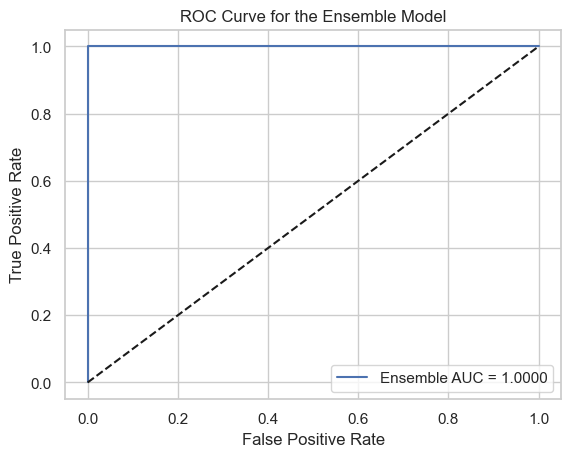

In [91]:
# step 8: compute metrics
ensemble_preds_pos_neg = np.concatenate([ensemble_preds_pos, ensemble_preds_neg]) # stack predictions, positive first
ensemble_probs_pos_neg = np.concatenate([ensemble_probs_pos, ensemble_probs_neg]) # stack prediction probabilities, positive first
y_test_pos_neg = np.concatenate([np.ones(len(ensemble_preds_pos)), np.zeros(len(ensemble_preds_neg))]) # 1s for positive edges, 0s for negative edges

accuracy = accuracy_score(y_test_pos_neg, ensemble_preds_pos_neg)
auroc = roc_auc_score(y_test_pos_neg, ensemble_probs_pos_neg)
precision = precision_score(y_test_pos_neg, ensemble_preds_pos_neg, zero_division=0)
print("\nEnsemble Model Test Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"Precision: {precision:.4f}")


fpr, tpr, thresholds = roc_curve(y_test_pos_neg, ensemble_probs_pos_neg)
plt.figure()
plt.plot(fpr, tpr, label=f"Ensemble AUC = {auroc:.4f}")
plt.plot([0, 1], [0, 1], "k--")  # random predictions diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for the Ensemble Model")
plt.legend(loc="best")
plt.show()


Well, now its either:
1. The task is pretty simple and out model easily deals with it.
2. There is something wrong in our pipeline.

I checked everything and could not find any errors. But, just by looking at positive/negative edges features distributions, I would say the task is pretty simple for the model to solve.